# Example-45: Twiss (Beta functions sensitivity)

In [1]:
# In this example effect of systematic quadruple errors on Twiss parameters is illustrated

In [2]:
# Import

from random import random
from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from model.library.line import Line

from model.command.external import load_sdds
from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.twiss import twiss

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

psi_qx:Tensor = torch.tensor(parameters['dnux/dp'], dtype=torch.float64)
psi_qy:Tensor = torch.tensor(parameters['dnuy/dp'], dtype=torch.float64)

In [4]:
# Build and setup lattice

# Note, sextupoles are turned off and dipoles are linear 

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Set linear dipoles

for element in ring:
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# Compute nominal beta functions at BPMs

kn = torch.zeros(nq, dtype=torch.float64)

_, bqx, _, bqy = twiss(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, advance=True, limit=1, epsilon=None).T

print(bqx.shape)
print(bqy.shape)

torch.Size([17])
torch.Size([17])


In [7]:
# Compute beta functions at BPMs using MC

kns = 0.01*torch.randn((8192, nq), dtype=torch.float64)

_, bqxs, _, bqys = torch.vmap(lambda kn: twiss(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, advance=True, limit=1, epsilon=None), chunk_size=1024)(kns).swapaxes(0, -1)

print(bqxs.shape)
print(bqys.shape)

torch.Size([17, 8192])
torch.Size([17, 8192])


In [8]:
# Set beta beating

dqxs = 100*((bqx - bqxs.T)/bqx).T
dqys = 100*((bqy - bqys.T)/bqy).T

print(dqxs.shape)
print(dqys.shape)

torch.Size([17, 8192])
torch.Size([17, 8192])


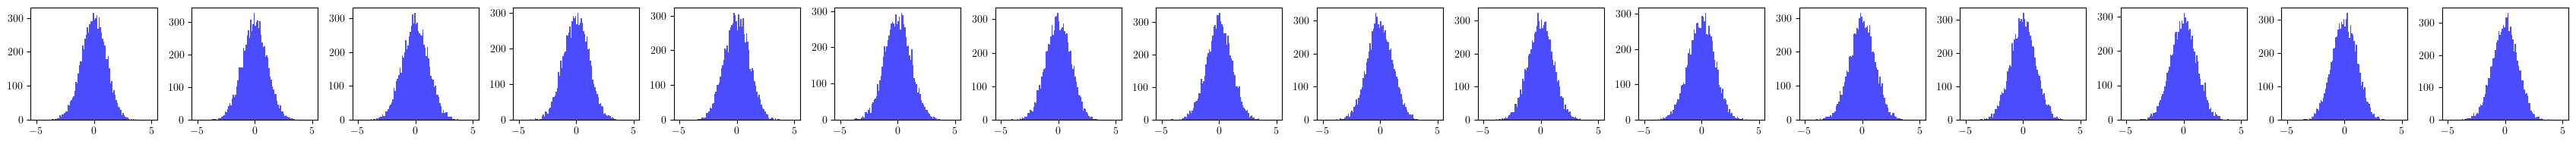

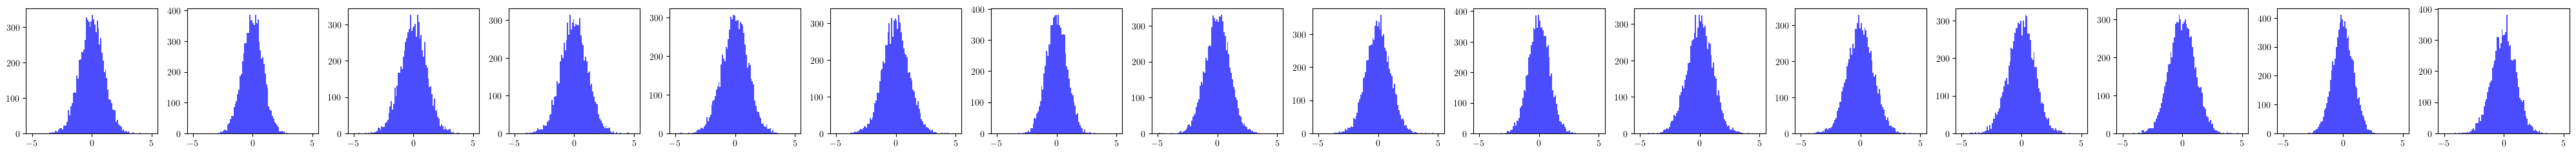

In [9]:
# Plot histograms

fig, axs = plt.subplots(1, len(ring), figsize=(17*2, 2))
for dqx, ax in zip(dqxs, axs):
    ax.hist((dqx - dqx.mean()).cpu().numpy(), bins=100, range=(-5.0, +5.0), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()    

fig, axs = plt.subplots(1, len(ring), figsize=(len(ring)*2.5, 2.5))
for dqy, ax in zip(dqys, axs):
    ax.hist((dqy - dqy.mean()).cpu().numpy(), bins=100, range=(-5.0, +5.0), color='blue', alpha=0.7)    
plt.tight_layout() 
plt.show()

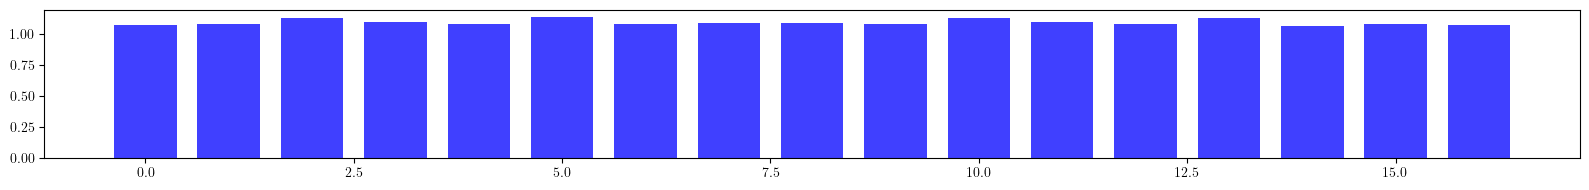

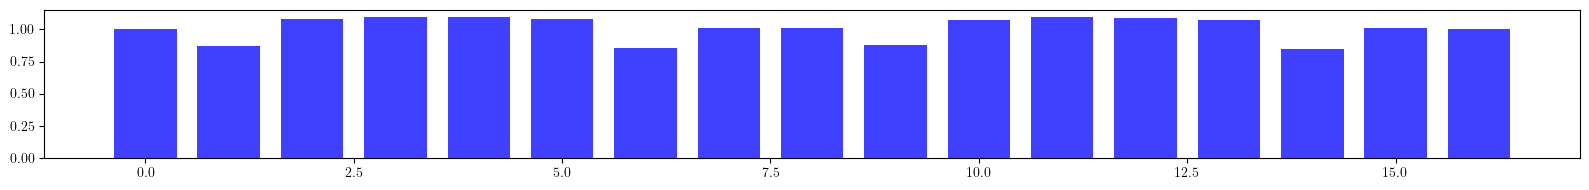

In [10]:
# Compute and plot spreads

sigma_dqxs = dqxs.std(1)
sigma_dqys = dqys.std(1)

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqxs)), sigma_dqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqys)), sigma_dqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

torch.Size([17, 28])
torch.Size([17, 28])


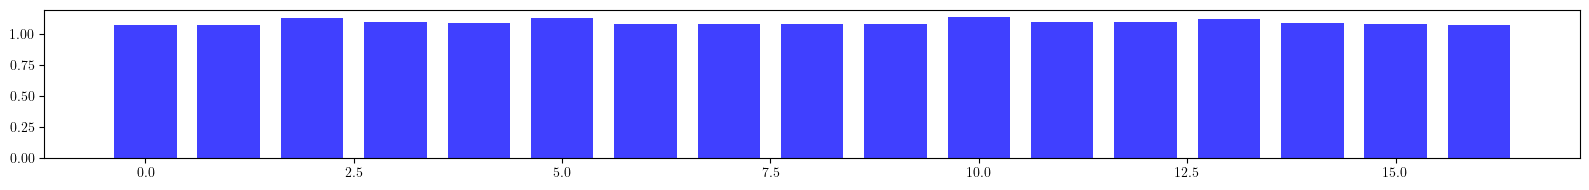

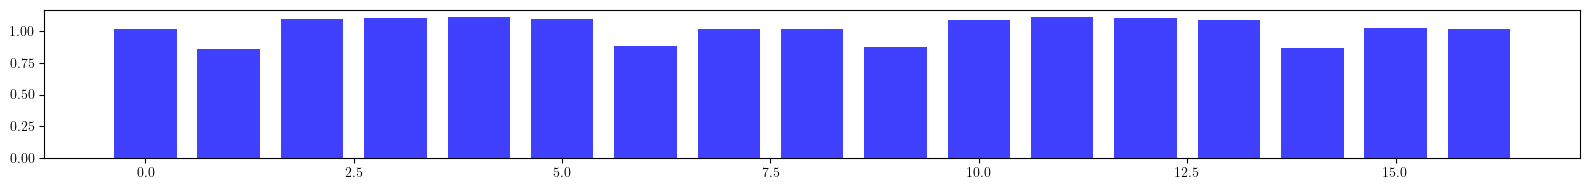

In [11]:
# Compute twiss derivatives and estimate spread from linear surrogate model using MC

# Compute derivatives

kn = torch.zeros(nq, dtype=torch.float64)
_, dbqx_dk, _, dbqy_dk = torch.func.jacrev(lambda kn: twiss(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, advance=True, limit=1, epsilon=None), chunk_size=1024)(kn).swapaxes(0, 1)

print(dbqx_dk.shape)
print(dbqy_dk.shape)

# Sample

kns = 0.01*torch.randn((8192, nq), dtype=torch.float64)

dqxs = 100*((dbqx_dk @ kns.T).T/bqx).T
dqys = 100*((dbqy_dk @ kns.T).T/bqy).T

# Compute and plot spreads

sigma_dqxs = dqxs.std(1)
sigma_dqys = dqys.std(1)

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqxs)), sigma_dqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqys)), sigma_dqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

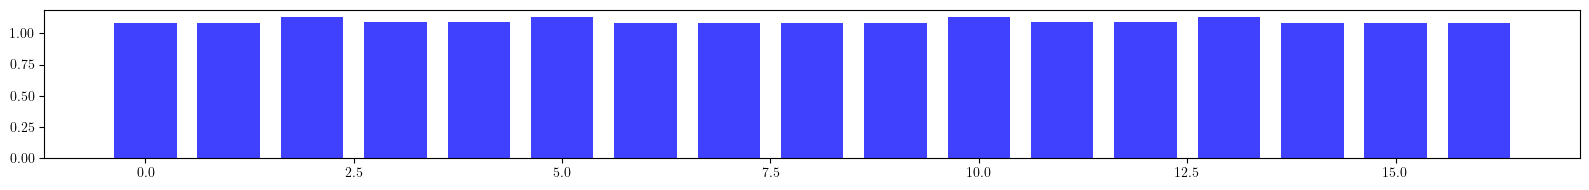

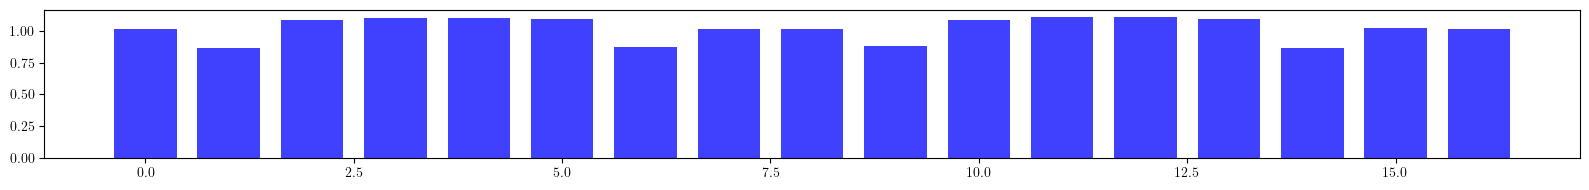

In [12]:
# Compute spread using error propagation

sigma_dqxs = 100*(dbqx_dk @ (0.01*torch.eye(nq,  dtype=torch.float64))**2 @ dbqx_dk.T).diag().sqrt()/bqx
sigma_dqys = 100*(dbqy_dk @ (0.01*torch.eye(nq,  dtype=torch.float64))**2 @ dbqy_dk.T).diag().sqrt()/bqy

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqxs)), sigma_dqxs.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(sigma_dqys)), sigma_dqys.cpu().numpy(), color='blue', alpha=0.75, width=0.75)
plt.tight_layout()
plt.show()